# Introduction

Disclaimer:
This Notebook is inspired by the great notebook by Evan Juras.
You can find the original jupyter book here: (https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models)

This notebook shows you how to train your own YOLOv8 Object detection model and export it for the IMX500 Sensor (e.g. for the Raspberry Pi AI Camera).


### How to use Colab
Colab is a tool by Google, that allows you to use High End GPUs and TPUs to train and convert AI models fast. It creates a virtual machine in your browser complete with a Linux OS, filesystem and Python environment. You can click the play buttons to excecute code.






**Connect to VM**

Connect to the Virtual machine in the top right corner. Change the Type from CPU to GPU (e.g. T4)

#Before you start

This tutorial is based on images labeled with Label-Studio.
If you use a different labeling software, ensure your labeled data is in the following structure:

An "images" folder containing the images
A "labels" folder containing the labels in YOLO annotation format
A classes.txt labelmap file that contains all the classes
A notes.json file that contains info specific to Label Studio (this file can be ignored)

# Upload your images

Zip your labled images and name the file data (data.zip is the final name)
The data.zip folder should have the following structure and names:
data.zip
- images
- labels
- classes.txt
- (notes.json)

Upload you zipped labeled images into the file directionary

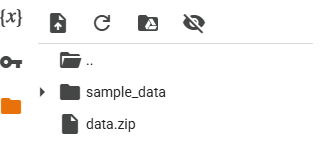


In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

For training, you need the images(and label files) sorted into two folders: Training and Validation. Use the code below to automaticaly and randomly split your dataset. You can choose the percentage for the split with the "--train_pct" parameter

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

# 3.&nbsp;Install Ultralytics

For training and exporting we use the Ultralytics toolkit. Install it with the command below

In [ ]:
!pip install ultralytics

# 4.&nbsp;Configure Training


Now you only have to create a .yaml file, that stores all the different classes and paths to the validation and training files.

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

# 5.&nbsp;Train Model

## 5.1 Training Parameters
After all the data is organized, were ready for training.
Altough you could train yolov5 and yolo11 models, only yolov8 models are tested and recommended by us! There are different model sizes (n, s, m, x and xl). The IMX500 Sensor only supports **n**ano models.

###Parameters:
**Number of epochs (`epochs`)**
The number of epochs is how often the training goes over the dataset. For smaller models(<200 Images) use 60 epochs. Otherwise, use 40 epochs.


**Resolution (`imgsz`)**

You can use the 640x640 resolution, it's what works best with the IMX500 Sensor and YOLOv8 Models. For faster models, you can use the 320x320 resolution


## 5.2 Run Training

Run the following code block to begin training. If you want to use a different number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [ ]:
!yolo detect train data=/content/data.yaml model=yolov8n.pt epochs=60 imgsz=640

The Training might take some time, so don't quit it early, as it optimizes the model in the end

#6.&nbsp;Test Model

After successful training, you can test the model. It's stored under runs/detect/train/weights/best.pt

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:66]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model now should draw boxes with confidence values around the objects. If the model isn't working as expected, make sure you labeled everything correctly and took good photos. You can also increase picture amount and epochs

#7.&nbsp;Deploy Model

If you're satisfied with the results, it's time for exporting it to the IMX500 Sensor. You have to install the MCT(Model compression Toolkit) by Sony. Also, install all other plugins below

In [ ]:
!pip install model_compression_toolkit

In [ ]:
!pip install edge-mdt-tpc

In [ ]:
!pip install sony-custom-layers

In [ ]:
!pip install imx500-converter[pt]

Now that everything is installed correctly, you can run the PTQ(Post Training Quantization) and export for the IMX500 sensor(This will take some time)

In [ ]:
!wget -O /content/converter.py https://raw.githubusercontent.com/Fazeli24/YOLOv8/refs/heads/main/converter.py

!python converter.py

Move the resulting .zip file to your main directory:

In [ ]:
!mv runs/detect/train/weights/best_imx_model/packerOut.zip packerOut.zip

You can now download the packagerOut.zip file from the left file bar

#Deployment
Now you have a quantized model ready for deployment on your Sony AI Camera! For this last step, you need your Raspberry Pi (3-5). Move your packerOut.zip file to a directory of the pi.
Start by installing the imx500 toolkit using the terminal:


---



####sudo apt install imx500-all imx500-tools




then, convert the packerOut.zip file to a network.rpk file:



####imx500-package -i path/to/packerOut.zip -o path/to/output/folder


---



Replace "path/to/packerOut.zip" with you path to the packerOut.zip file and "path/to/output/folder" to your chosen output folder.

You now have a completly converted and quantized model file to run on your IMX500 Sensor.